In [1]:
import numpy as np 

In [2]:
data_denorm = np.loadtxt("data/multipleFeaturesExtended.csv", delimiter=",")

In [3]:
print(data_denorm[:10,:])

[[2.2e+03 3.0e+00 2.0e+00 1.0e+01 3.4e+05]
 [2.4e+03 4.0e+00 3.0e+00 6.0e+00 4.3e+05]
 [2.8e+03 3.0e+00 3.0e+00 5.0e+00 4.2e+05]
 [2.1e+03 2.0e+00 1.0e+00 8.0e+00 2.7e+05]
 [2.9e+03 4.0e+00 2.0e+00 3.0e+00 4.5e+05]
 [2.3e+03 3.0e+00 2.0e+00 7.0e+00 3.6e+05]
 [2.0e+03 2.0e+00 1.0e+00 9.0e+00 2.8e+05]
 [3.1e+03 4.0e+00 3.0e+00 2.0e+00 5.1e+05]
 [2.5e+03 3.0e+00 2.0e+00 8.0e+00 3.8e+05]
 [2.4e+03 3.0e+00 2.0e+00 7.0e+00 3.7e+05]]


In [4]:
from sklearn.preprocessing import StandardScaler

'''
data_norm = (data_denorm - np.mean(data_denorm, axis=0)) / np.std(data_denorm, axis=0)
'''

scaler = StandardScaler()
norm_scaler_data = scaler.fit_transform(data_denorm)


from sklearn.model_selection import train_test_split

X_main, X_extra, y_main, y_extra = train_test_split(norm_scaler_data[:,0:4], norm_scaler_data[:,4], test_size=0.5)

X_train, X_cross_test, y_train, y_cross_test = train_test_split(X_main, y_main, test_size=0.4)
X_cross, X_test, y_cross, y_test = train_test_split(X_cross_test, y_cross_test, test_size=0.5)


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.activations import relu, linear

#Apple Silicon: optimizers.legacy.Adam
#Base: optimizers.Adam
from tensorflow.keras.optimizers.legacy import Adam

from tensorflow.keras import regularizers

In [6]:
print(X_train.shape)

(36, 4)


In [7]:
'''
# 60 20 20

#using the entire dataset.

train_set = data_norm[:72,:]
dev_set = data_norm[72:72 + 24,:]
test_set = data_norm[72 + 24:,:]
'''

'\n# 60 20 20\n\n#using the entire dataset.\n\ntrain_set = data_norm[:72,:]\ndev_set = data_norm[72:72 + 24,:]\ntest_set = data_norm[72 + 24:,:]\n'

In [8]:
tf.random.set_seed(15)

model = Sequential(
    [ 
        Input(shape=(4,)),
        Dense(10, activation = 'relu',name='l1',kernel_regularizer=regularizers.L2(l2=0.05)),
        Dense(5, activation = 'relu',name='l2',kernel_regularizer=regularizers.L2(l2=0.05)),
        Dense(1, activation = 'linear',name='l3',kernel_regularizer=regularizers.L2(l2=0.05)) 
    ]
)

model.compile(
    loss = MeanSquaredError(),
    optimizer = Adam(0.01)
)

model.fit(
    X_train,y_train,
    epochs = 50
)

Epoch 1/50
2/2 [==============================] - 0s 3ms/step - loss: 4.2468
Epoch 2/50
2/2 [==============================] - 0s 1ms/step - loss: 3.3233
Epoch 3/50
2/2 [==============================] - 0s 2ms/step - loss: 2.6592
Epoch 4/50
2/2 [==============================] - 0s 2ms/step - loss: 2.1056
Epoch 5/50
2/2 [==============================] - 0s 2ms/step - loss: 1.7516
Epoch 6/50
2/2 [==============================] - 0s 2ms/step - loss: 1.5294
Epoch 7/50
2/2 [==============================] - 0s 1ms/step - loss: 1.3250
Epoch 8/50
2/2 [==============================] - 0s 1ms/step - loss: 1.1635
Epoch 9/50
2/2 [==============================] - 0s 2ms/step - loss: 1.0539
Epoch 10/50
2/2 [==============================] - 0s 2ms/step - loss: 0.9617
Epoch 11/50
2/2 [==============================] - 0s 2ms/step - loss: 0.9003
Epoch 12/50
2/2 [==============================] - 0s 1ms/step - loss: 0.8418
Epoch 13/50
2/2 [==============================] - 0s 2ms/step - loss: 0.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l1 (Dense)                  (None, 10)                50        
                                                                 
 l2 (Dense)                  (None, 5)                 55        
                                                                 
 l3 (Dense)                  (None, 1)                 6         
                                                                 
Total params: 111 (444.00 Byte)
Trainable params: 111 (444.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import PolynomialFeatures

#supressing TF warnings, only showing ERROR messages
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


np.random.seed(15)
tf.random.set_seed(15)

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# MSE calculator
mse_calculator = MeanSquaredError()

training_mse = []
crossValidation_mse = []

#tf MSE's
training_mse_tf = []  
crossValidation_mse_tf = []  

num_runs = 10  # no. of times to run the training process

best_mse = np.inf  # MSE to infinity
best_weights = None 
best_degree = None

# looping through each degree
for i in range(1, 6):

    train_mse_sum = 0.0
    cross_mse_sum = 0.0
    train_mse_tf_sum = 0.0 
    cross_mse_tf_sum = 0.0 

    for _ in range(num_runs):

        model.reset_states()
        
        poly = PolynomialFeatures(degree=i, include_bias=False)
        X_train_poly = poly.fit_transform(X_train)
        X_cross_poly = poly.transform(X_cross)
        
        input_shape = X_train_poly.shape[1]

        model = Sequential(
            [
                Input(shape=(input_shape,)),
                Dense(20, activation='relu', name='l1', kernel_regularizer=regularizers.L2(l2=0.01)),
                BatchNormalization(),
                Dense(15, activation='relu', name='l2', kernel_regularizer=regularizers.L2(l2=0.01)),
                BatchNormalization(),
                Dense(1, activation='linear', name='l3', kernel_regularizer=regularizers.L2(l2=0.01))
            ]
        )

        model.compile(
            loss=MeanSquaredError(),
            optimizer=Adam(0.01)
        )

        # training the model with early stopping
        model.fit(
            X_train_poly, y_train,
            epochs=100,
            callbacks=[early_stop],
            validation_data=(X_cross_poly, y_cross),
            verbose=0
        )

        train_predict = model.predict(X_train_poly)
        cross_predict = model.predict(X_cross_poly)

        #MSE with formula
        train_mse = ((train_predict.reshape(-1,) - y_train) ** 2).mean()  
        cross_mse = ((cross_predict.reshape(-1,) - y_cross) ** 2).mean() 

        # MSE with MeanSquaredError
        y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_cross_tensor = tf.convert_to_tensor(y_cross, dtype=tf.float32)

        train_mse_tf_current = mse_calculator(y_train_tensor, tf.squeeze(train_predict)).numpy()  
        cross_mse_tf_current = mse_calculator(y_cross_tensor, tf.squeeze(cross_predict)).numpy()
        
        train_mse_sum += train_mse
        cross_mse_sum += cross_mse
        train_mse_tf_sum += train_mse_tf_current
        cross_mse_tf_sum += cross_mse_tf_current

    training_mse.append(train_mse_sum / num_runs)
    crossValidation_mse.append(cross_mse_sum / num_runs)
    training_mse_tf.append(train_mse_tf_sum / num_runs)
    crossValidation_mse_tf.append(cross_mse_tf_sum / num_runs)
    
     # checking if current model's mse is better than the best_mse
    if cross_mse_sum < best_mse:
        best_mse = cross_mse_sum
        best_weights = model.get_weights()  # saving the best model's weights
        best_degree = i 


#print(best_weights)

# Print MSE arrays
print("MSE with formula - Training:", training_mse)
print("MSE with formula - Cross-validation:", crossValidation_mse)
print("MSE with TensorFlow - Training:", training_mse_tf)
print("MSE with TensorFlow - Cross-validation:", crossValidation_mse_tf)


1/1 [==============================] - 0s 9ms/step
MSE with formula - Training: [0.5115994859130614, 0.4664335519761937, 2.0701270285216617, 1.8098332747279957, 1.8256471339434384]
MSE with formula - Cross-validation: [0.5892602611180434, 0.4825594125025118, 1.5195280806335836, 0.7399268610685726, 1.2046002479925884]
MSE with TensorFlow - Training: [0.5115995094180107, 0.46643355637788775, 2.070126950740814, 1.8098333835601808, 1.8256471306085587]
MSE with TensorFlow - Cross-validation: [0.5892602622509002, 0.48255944550037383, 1.5195280626416205, 0.7399268761277199, 1.2046002626419068]


[0.5115994859130614, 0.4664335519761937, 2.0701270285216617, 1.8098332747279957, 1.8256471339434384]
[0.5892602611180434, 0.4825594125025118, 1.5195280806335836, 0.7399268610685726, 1.2046002479925884]


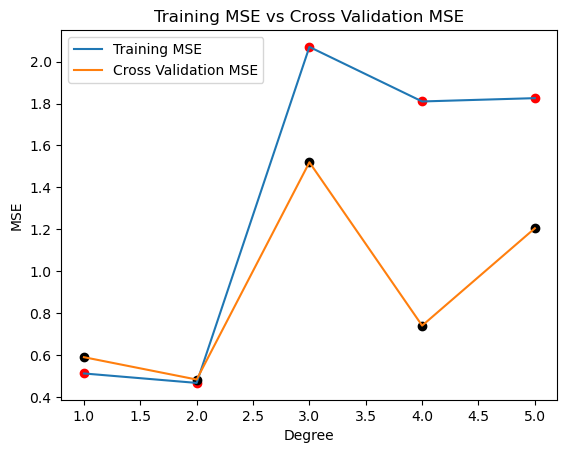

In [39]:
print(training_mse)
print(crossValidation_mse)
      
import matplotlib.pyplot as plt

x = range(1, len(training_mse) + 1)

plt.plot(x, training_mse, label='Training MSE')
plt.scatter(x,training_mse,c='r')

plt.plot(x, crossValidation_mse, label='Cross Validation MSE')
plt.scatter(x,crossValidation_mse,c='black')

plt.xlabel('Degree')
plt.ylabel('MSE')
plt.title('Training MSE vs Cross Validation MSE')

plt.legend()

plt.show()
      

In [40]:
mse_ = np.column_stack((training_mse, crossValidation_mse))
mse_tf_ = np.column_stack((training_mse_tf, crossValidation_mse_tf))
np.set_printoptions(precision=10)
print("Formula:",mse_,end='\n\n')
print("TF MSE:",mse_tf_)

print("\nDegree:",best_degree)

Formula: [[0.5115994859 0.5892602611]
 [0.466433552  0.4825594125]
 [2.0701270285 1.5195280806]
 [1.8098332747 0.7399268611]
 [1.8256471339 1.204600248 ]]

TF MSE: [[0.5115995094 0.5892602623]
 [0.4664335564 0.4825594455]
 [2.0701269507 1.5195280626]
 [1.8098333836 0.7399268761]
 [1.8256471306 1.2046002626]]

Degree: 2


In [41]:
poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_test_poly = poly.fit_transform(X_test)
X_extra_poly = poly.transform(X_extra)

input_shape = X_test_poly.shape[1]
new_model = Sequential(
    [
        Input(shape=(input_shape,)),
        Dense(20, activation='relu', name='l1', kernel_regularizer=regularizers.L2(l2=0.01)),
        BatchNormalization(),
        Dense(15, activation='relu', name='l2', kernel_regularizer=regularizers.L2(l2=0.01)),
        BatchNormalization(),
        Dense(1, activation='linear', name='l3', kernel_regularizer=regularizers.L2(l2=0.01))
    ]
)

new_model.set_weights(best_weights)

test_predict = new_model.predict(X_test_poly)
extra_predict = new_model.predict(X_extra_poly)

test_mse = ((test_predict.reshape(-1,) - y_test) ** 2).mean() 
extra_mse = ((extra_predict.reshape(-1,) - y_extra) ** 2).mean() 

# MSE with MeanSquaredError
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
y_extra_tensor = tf.convert_to_tensor(y_extra, dtype=tf.float32)

test_mse_tf = mse_calculator(y_test_tensor, tf.squeeze(test_predict)).numpy()  
extra_mse_tf = mse_calculator(y_extra_tensor, tf.squeeze(extra_predict)).numpy()

print("Formula:")
print("Test -",test_mse)
print("Extra -",extra_mse)

print("\nMSE Library:")
print("Test -",test_mse_tf)
print("Extra -",extra_mse_tf)

2/2 [==============================] - 0s 1ms/step
Formula:
Test - 0.5579796000769403
Extra - 0.6426205230936117

MSE Library:
Test - 0.55797964
Extra - 0.6426205


In [42]:
#Neural Net 
# creating subplots (ORIGINAL - box, RAW - *, ROUNDED - .) 
X_check = data_denorm[:,:-1]
y_check = data_denorm[:,-1]


poly_check = PolynomialFeatures(degree=best_degree, include_bias=False)
X_poly = poly_check.fit_transform(norm_scaler_data[:,:-1])

print(norm_scaler_data.shape)
print(X_poly.shape)



(120, 5)
(120, 14)


In [46]:
prediction = new_model.predict(X_poly)

#de_normalized = normalized * std(y) + mean(y)
prediction_NN_UR = prediction * np.std(y_check) + np.mean(y_check) 
prediction_NN = np.round(prediction_NN_UR/ 10000) * 10000

print("Prediction_NN:\n",prediction_NN[:5,:].reshape(-1,),"...")
print("\nOriginal data:\n",data_denorm[:5,-1],"...")

mse_calculater = MeanSquaredError()
dataset_mse = ((prediction_NN.reshape(-1,)/100000 - data_denorm[:,-1]/100000) ** 2).mean()  

#factored by /100000
#compare with multipleFeatureLinearRegression.ipynb
print(f"\nDataset MSE: {dataset_mse}")

4/4 [==============================] - 0s 839us/step
Prediction_NN:
 [380000. 410000. 420000. 390000. 410000.] ...

Original data:
 [340000. 430000. 420000. 270000. 450000.] ...

Dataset MSE: 0.22824999999999995


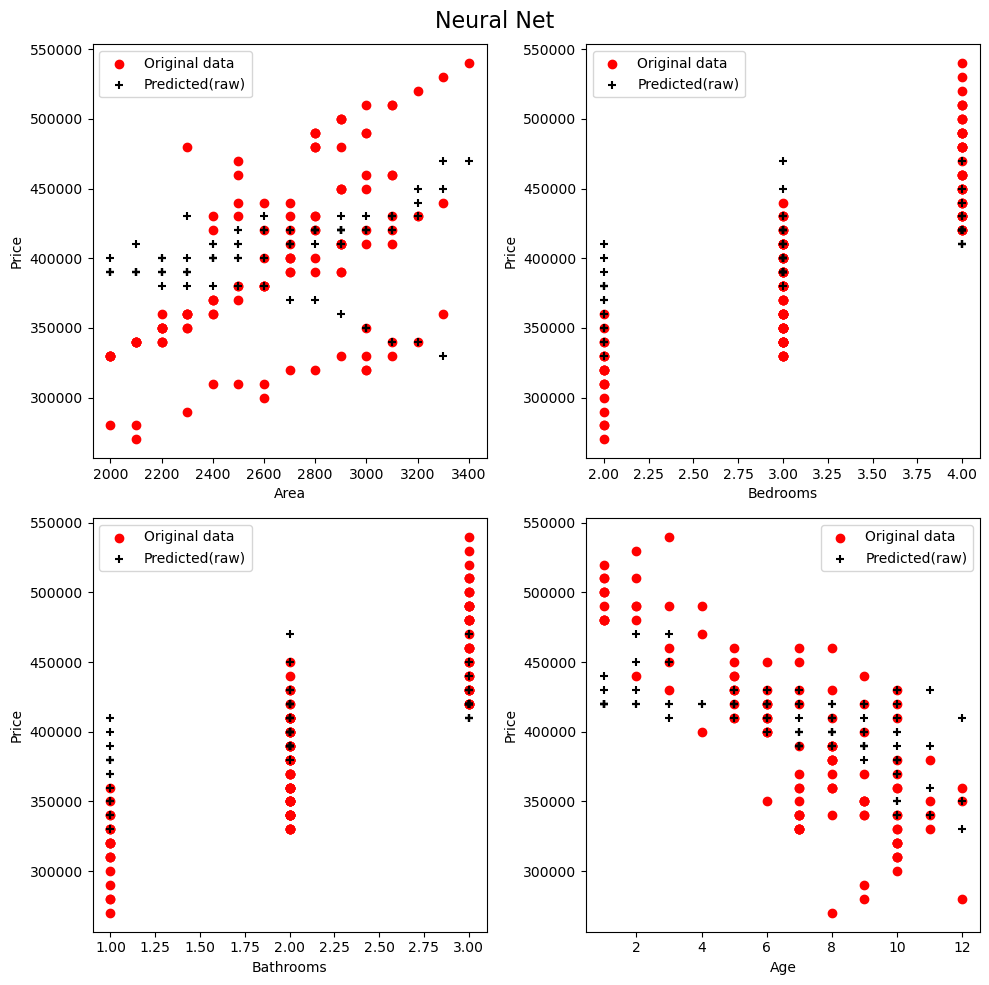

In [48]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# Set a title for the entire figure
fig.suptitle('Neural Net', fontsize=16)
features = ['Area', 'Bedrooms', 'Bathrooms', 'Age']

# looping over each subplot to plot data
for i in range(2):
    for j in range(2):
        index = 2*i + j  # calculating the index
        axs[i, j].scatter(X_check[:,index], y_check, marker='o', color='red', label='Original data')
        axs[i, j].scatter(X_check[:,index], prediction_NN, marker='+', color='black', label='Predicted(raw)')
        axs[i, j].set_xlabel(features[index])
        axs[i, j].set_ylabel('Price')
        axs[i, j].legend()

# displaying the figure with subplots
plt.tight_layout()
plt.show()
